The goal of this analysis is two-fold. The first goal is to see what features correlate with cancellations to help generate hypotheses around what product improvements could reduce the number of cancellations. The second goal is attempt to confidently predict when a visitor might cancel and to use that model to optimally overbook the hotel. The data for this analysis can be found here: https://www.kaggle.com/datasets/mojtaba142/hotel-booking

As our first step, let's import our packages and our data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import chi2_contingency
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import optuna

import shap

from catboost import CatBoostClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = pd.read_csv('./hotel_booking.csv')

/home/markc/Desktop/PythonProjects/NaturalLanguageProcessing/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's begin with some basic checking of data types and counts

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

For the most part, our data is very complete. There are only four columns missing data, and only two are missing a significant amount of data. Let's inspect these four columns to figure the best way to handle the missing data.

In [3]:
data[['children', 'country', 'agent', 'company']].head(5)

,children,country,agent,company
0,0.0,PRT,NaN,NaN
1,0.0,PRT,NaN,NaN
2,0.0,GBR,NaN,NaN
3,0.0,GBR,304.0,NaN
4,0.0,GBR,240.0,NaN


At a glance, there doesn't seem to be a great way to impute values for children and country. Given that the missing data here is less that 0.5% of the data set, it is likley safe to drop these values. As for agent and company, these look more like integers indicating a category than floats, and it will likely be sufficient to create a new category that represents not have anything rather than a null value.

In [4]:
data = data.dropna(subset=['children','country'])

In [5]:
data[['agent', 'company']].describe()

,agent,company
count,102894.000000,6623.000000
mean,86.545532,189.624792
std,110.714259,132.124298
min,1.000000,6.000000
25%,9.000000,62.000000
50%,14.000000,179.000000
75%,229.000000,270.000000
max,535.000000,543.000000


Since the minimum values for both agent and company are greater than zero, we can indicate a lack of information by filling with 0. we will also convert the data to strings so that we do not accidentally use it for numeric analysis.

In [6]:
data[['agent', 'company']] = data[['agent', 'company']].fillna(0).astype(str)
data.loc['children',:] = data['children'].astype(int)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118899 entries, 0 to children
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118898 non-null  object 
 1   is_canceled                     118898 non-null  float64
 2   lead_time                       118898 non-null  float64
 3   arrival_date_year               118898 non-null  float64
 4   arrival_date_month              118898 non-null  object 
 5   arrival_date_week_number        118898 non-null  float64
 6   arrival_date_day_of_month       118898 non-null  float64
 7   stays_in_weekend_nights         118898 non-null  float64
 8   stays_in_week_nights            118898 non-null  float64
 9   adults                          118898 non-null  float64
 10  children                        118898 non-null  float64
 11  babies                          118898 non-null  float64
 12  meal               

Now, let's get an overall view of our distributions

In [8]:
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000
mean,0.371352,104.311435,2016.157656,27.166555,15.800880,0.928897,2.502145,1.858391,0.104207,0.007948,0.032011,0.087142,0.131634,0.221181,2.330754,102.003243,0.061885,0.571683
std,0.483168,106.903309,0.707459,13.589971,8.780324,0.996216,1.900168,0.578576,0.399172,0.097380,0.176029,0.845869,1.484672,0.652785,17.630452,50.485862,0.244172,0.792678
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


In [9]:
data.describe(include='object')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,agent,company,customer_type,reservation_status,reservation_status_date,name,email,phone-number,credit_card
count,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898
unique,2,12,5,177,7,5,10,12,3,333,350,4,3,926,81234,115425,118898,9000
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9.0,0.0,Transient,Check-Out,2015-10-21,Robert Smith,Michael.C@gmail.com,669-792-1661,************3627
freq,79302,13852,91863,48586,56402,97730,85601,73863,104163,31959,112275,89174,74745,1461,48,6,1,28


Let's look at the types of reservation status. Depending on the types, we may need to drop some data that is irrelevant. We want to see that all transactions are completed in some form.

In [10]:
data['reservation_status'].value_counts()

reservation_status
Check-Out    74745
Canceled     42950
No-Show       1203
Name: count, dtype: int64

In [11]:
data.loc[data['reservation_status'] == 'No-Show', 'is_canceled'].value_counts()

is_canceled
1.0    1203
Name: count, dtype: int64

All of our transactions are complete. No Shows are counted as being cancelled in the data set. This seems reasonable, although we might speculate that the underlying causes/reasons for no-showing are different than cancelling, the outcome is similar for the hotel. For a first pass, I think it is okay to treat them the same.

Now let's look at the differential distribution of some of our variables.

Skipped is_canceled
Successful 0 lead_time
Successful 1 arrival_date_year
Successful 2 arrival_date_week_number
Successful 3 arrival_date_day_of_month
Successful 4 stays_in_weekend_nights
Successful 5 stays_in_week_nights
Successful 6 adults
Successful 7 children
Successful 8 babies
Skipped is_repeated_guest
Successful 9 previous_cancellations
Successful 10 previous_bookings_not_canceled
Successful 11 booking_changes
Successful 12 days_in_waiting_list
Successful 13 adr
Skipped required_car_parking_spaces
Successful 14 total_of_special_requests


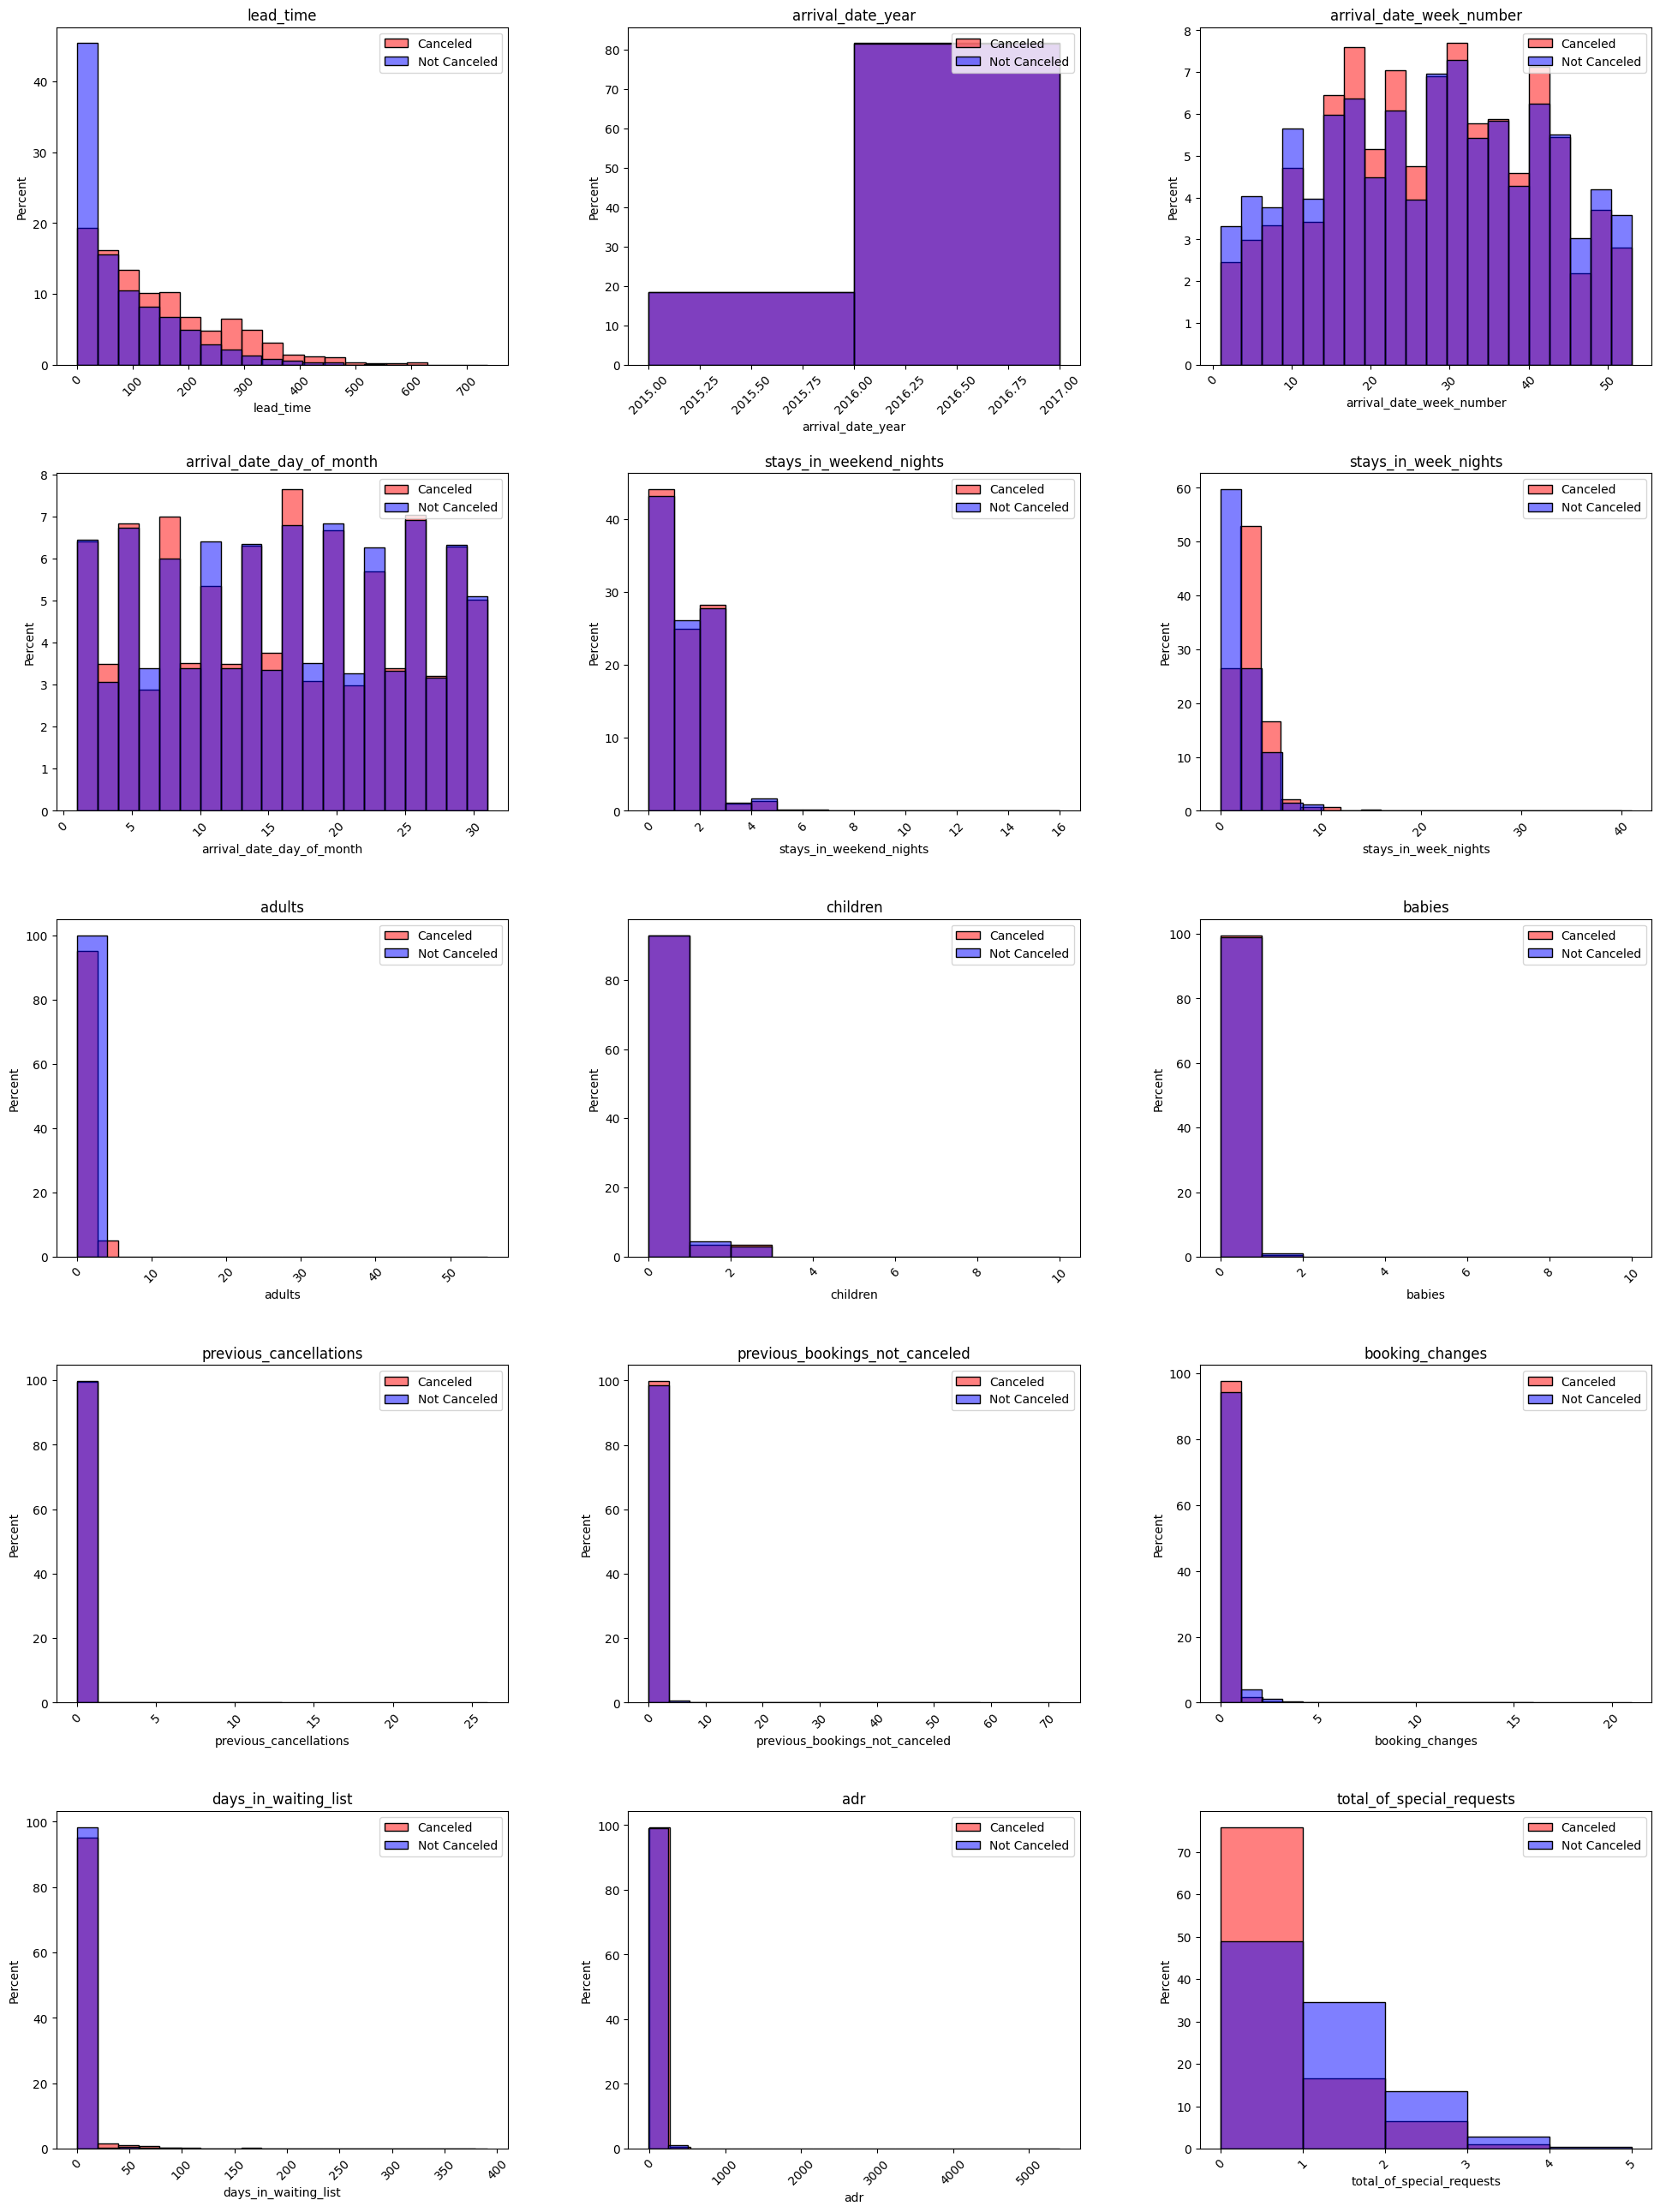

In [12]:
fig, ax = plt.subplots(5, 3, figsize=(21, 27))
fig.tight_layout(pad=7.0)
columns = data.select_dtypes(include=[np.number]).columns.tolist()

i=0
for col in columns:
    if data.loc[data['is_canceled']==1, col].nunique() <= 2 or data.loc[data['is_canceled']==0, col].nunique() <= 2:
        print("Skipped", col)
        continue
    print("Successful", i, col)
    width = max((data[col].max() - data[col].min())/20,1)
    sns.histplot(data.loc[data['is_canceled']==1,col], color = 'red', alpha=0.5, binwidth=width, stat='percent', ax=ax[i//3, i%3], label='Canceled')
    sns.histplot(data.loc[data['is_canceled']==0,col], color = 'blue', alpha=0.5, binwidth=width, stat='percent', ax=ax[i//3, i%3], label='Not Canceled')
    ax[i//3, i%3].set_title(col)
    ax[i//3, i%3].legend(loc='upper right')
    #Write code to rotate the x-axis labels 45 degrees for each subplot
    for tick in ax[i//3, i%3].get_xticklabels():
        tick.set_rotation(45)

    i += 1

Something we are clearly suffering from is that some columns have strong outliers, which reduced our ability to effectively evaluate the column. Let's write a function to remove outliers and look into the data further.

In [13]:
#write a function that removes outliers from the data

def remove_outliers(data, col):
    q1 = data[col].quantile(0.05)
    q3 = data[col].quantile(0.95)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return data.loc[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

#remove outliers from the data
temp = data.copy()[columns]
print(len(temp))
for col in columns:
    temp = remove_outliers(temp, col)
    print(len(temp), col)
temp.info()

118899
118898 is_canceled
118898 lead_time
118898 arrival_date_year
118898 arrival_date_week_number
118898 arrival_date_day_of_month
118635 stays_in_weekend_nights
118582 stays_in_week_nights
118569 adults
118492 children
117581 babies
113796 is_repeated_guest
108287 previous_cancellations
107813 previous_bookings_not_canceled
106404 booking_changes
103531 days_in_waiting_list
103526 adr
103523 required_car_parking_spaces
103523 total_of_special_requests
<class 'pandas.core.frame.DataFrame'>
Index: 103523 entries, 2 to 119389
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     103523 non-null  float64
 1   lead_time                       103523 non-null  float64
 2   arrival_date_year               103523 non-null  float64
 3   arrival_date_week_number        103523 non-null  float64
 4   arrival_date_day_of_month       103523 non-null  float64
 

Skipped is_canceled
Successful 0 lead_time
Successful 1 arrival_date_year
Successful 2 arrival_date_week_number
Successful 3 arrival_date_day_of_month
Successful 4 stays_in_weekend_nights
Successful 5 stays_in_week_nights
Successful 6 adults
Successful 7 children
Skipped babies
Skipped is_repeated_guest
Skipped previous_cancellations
Skipped previous_bookings_not_canceled
Successful 8 booking_changes
Skipped days_in_waiting_list
Successful 9 adr
Skipped required_car_parking_spaces
Successful 10 total_of_special_requests


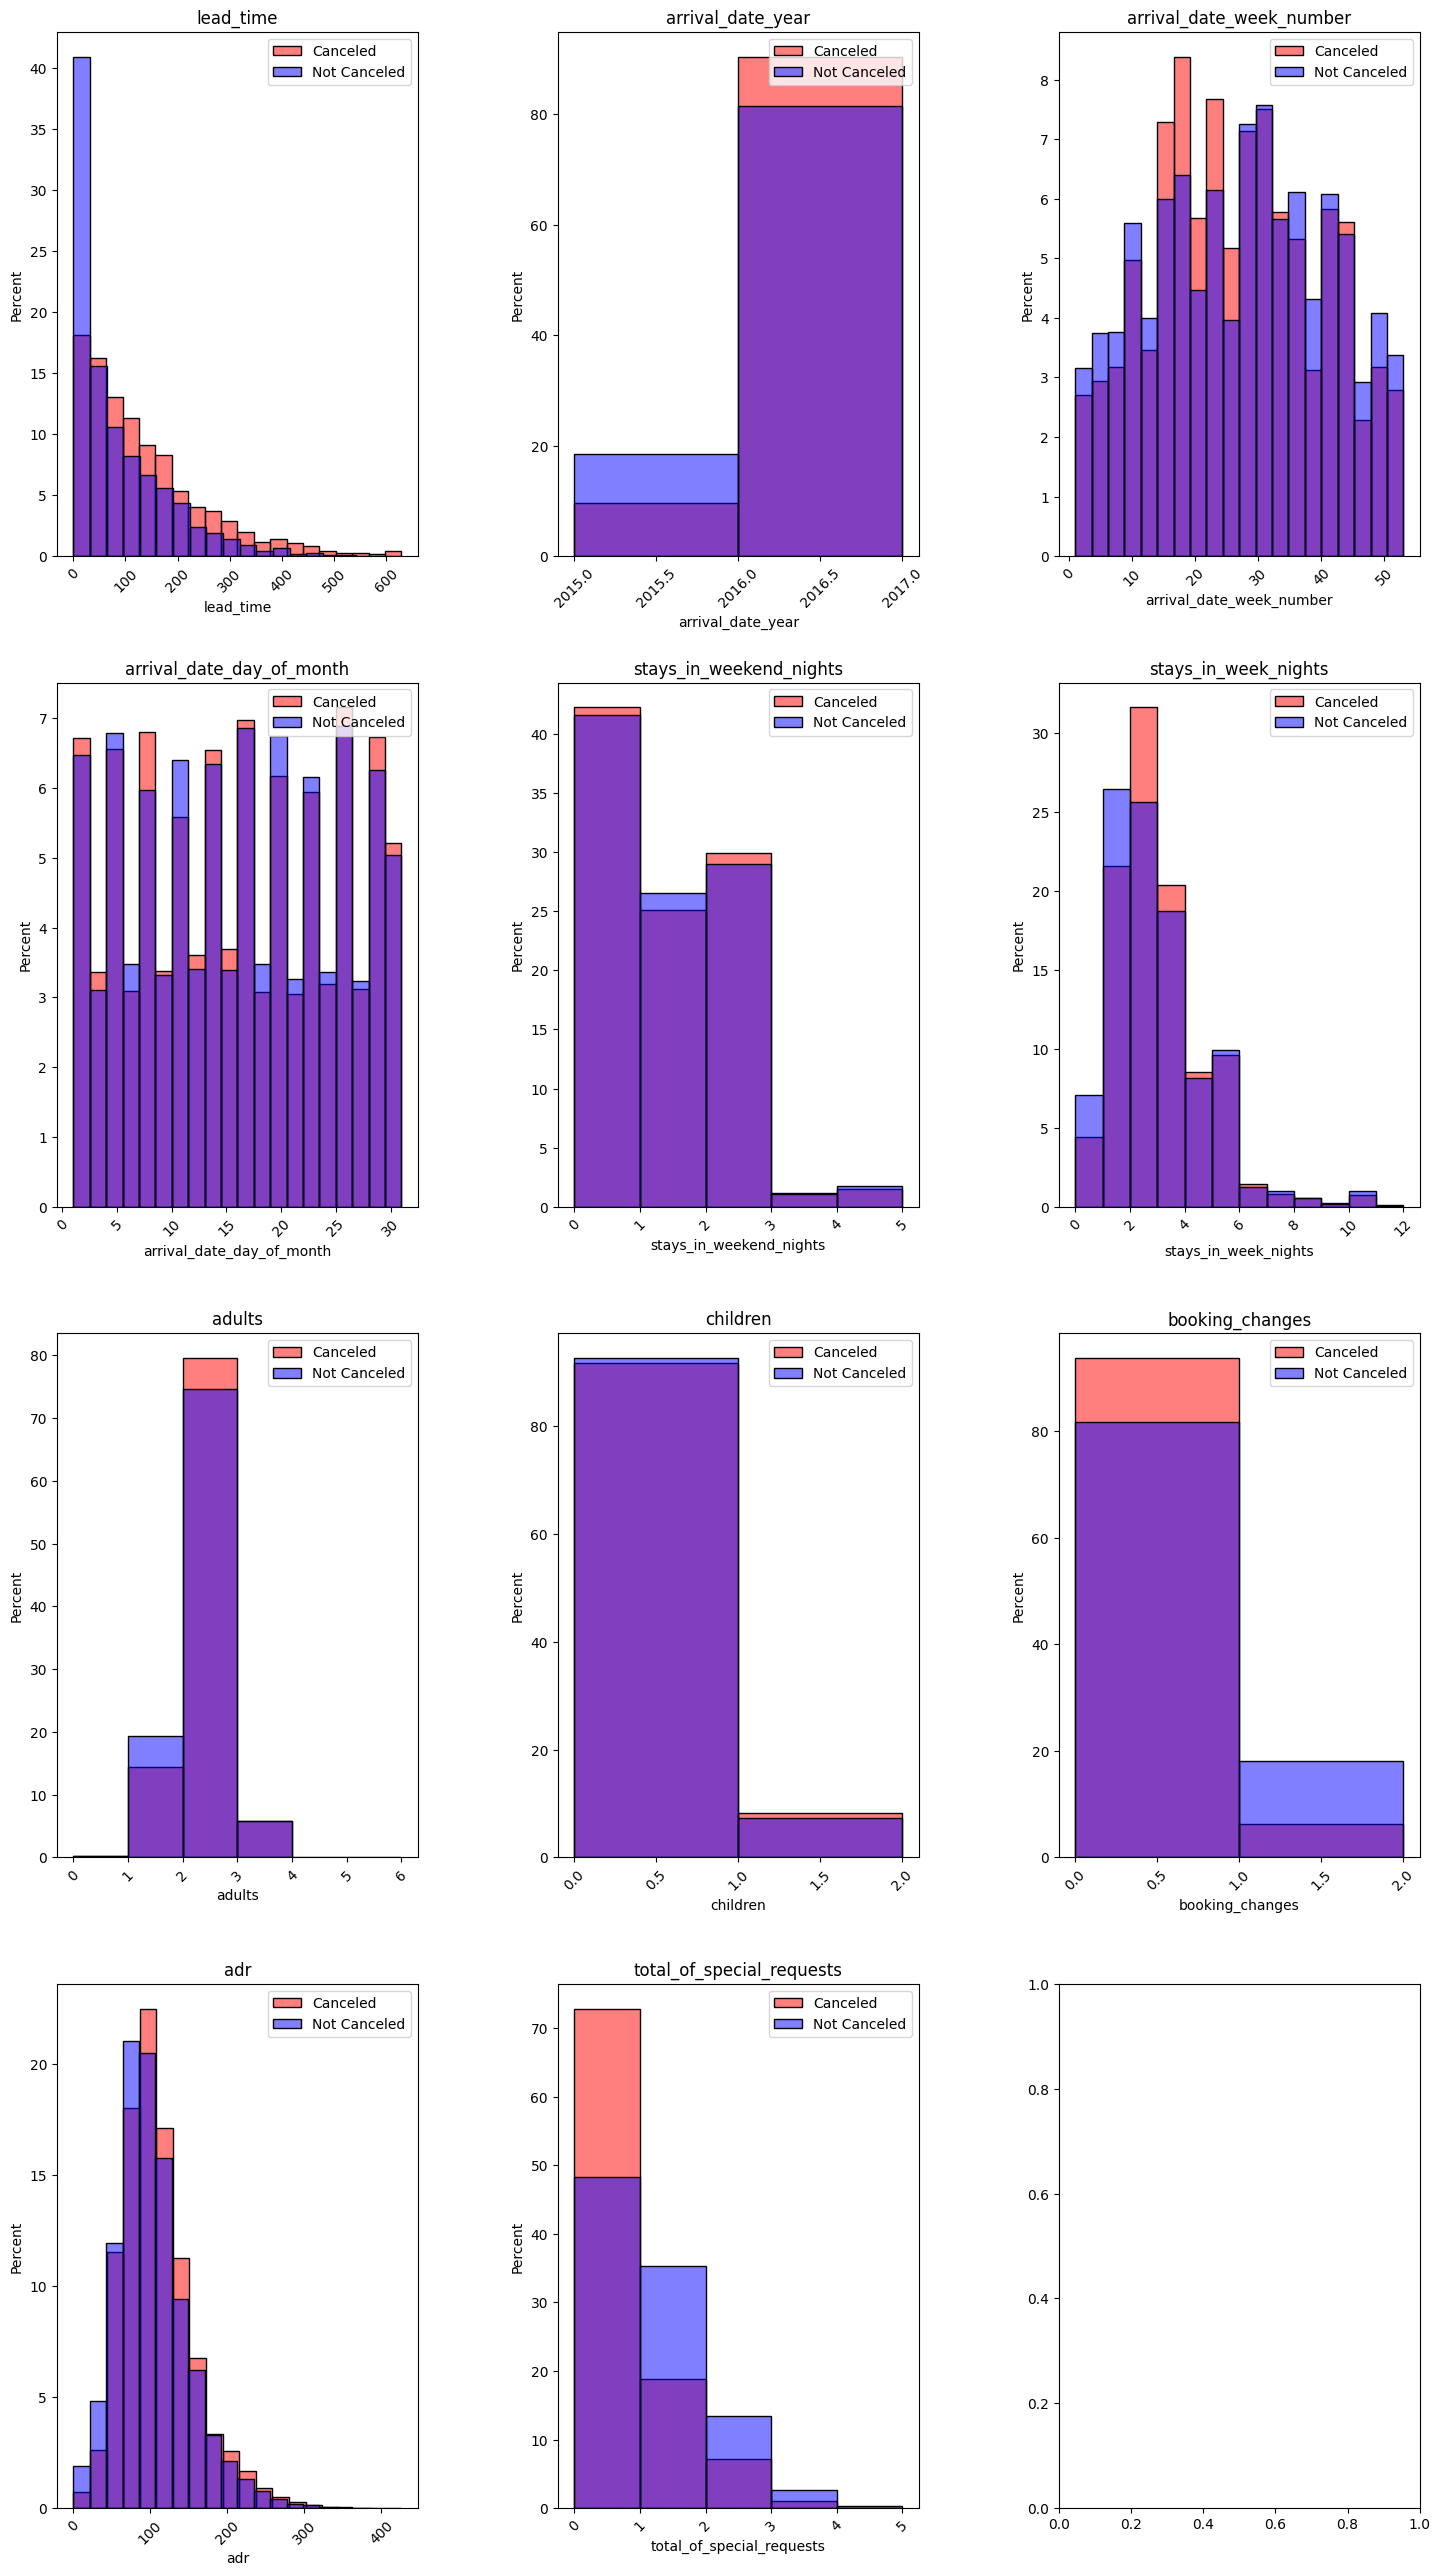

In [14]:
fig, ax = plt.subplots(4, 3, figsize=(16, 27))
fig.tight_layout(pad=7.0)
columns = temp.select_dtypes(include=[np.number]).columns.tolist()

i=0
for col in columns:
    if temp.loc[data['is_canceled']==1, col].nunique() <= 2 or temp.loc[data['is_canceled']==0, col].nunique() <= 2:
        print("Skipped", col)
        continue
    print("Successful", i, col)
    width = max((temp[col].max() - temp[col].min())/20,1)
    sns.histplot(temp.loc[temp['is_canceled']==1,col], color = 'red', alpha=0.5, binwidth=width, stat='percent', ax=ax[i//3, i%3], label='Canceled')
    sns.histplot(temp.loc[temp['is_canceled']==0,col], color = 'blue', alpha=0.5, binwidth=width, stat='percent', ax=ax[i//3, i%3], label='Not Canceled')
    ax[i//3, i%3].set_title(col)
    ax[i//3, i%3].legend(loc='upper right')
    #Write code to rotate the x-axis labels 45 degrees for each subplot
    for tick in ax[i//3, i%3].get_xticklabels():
        tick.set_rotation(45)

    i += 1

sns.pairplot(data[columns])

In [15]:
#sns.pairplot(data[columns])

That's a lot to look at, and in many ways isn't that informative. A correlation heatmap might be a better choice. 

<Axes: >

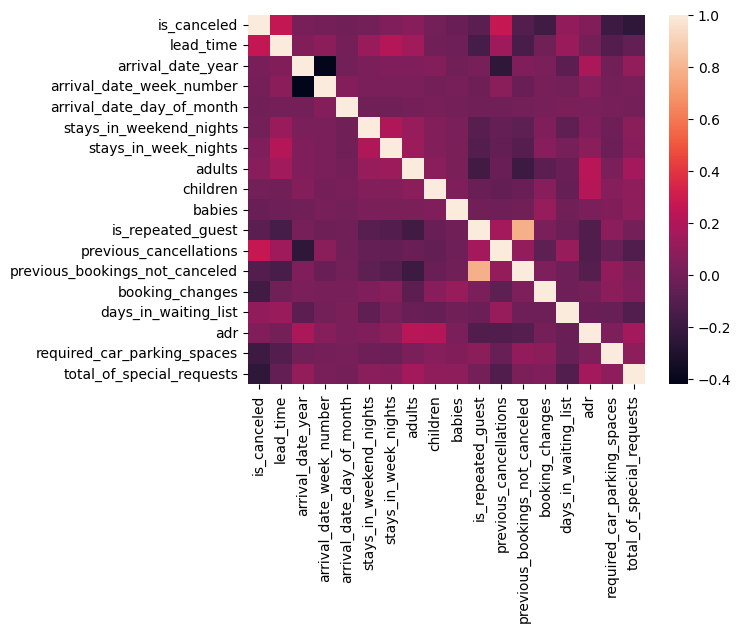

In [16]:
correlation = data[columns].corr(method='kendall')

sns.heatmap(correlation)

This tells us a lot of what we already knew, although in a much more condensed for. It is clear that there are some relatively strong positive correlations with is cancelled, like lead time and and previous cancellations. There are also some negative correlations, like previous booking changes, parking spaces, and special requests.

Now, let's move onto our categorical variables

In [17]:
data.describe(include='object')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,agent,company,customer_type,reservation_status,reservation_status_date,name,email,phone-number,credit_card
count,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898,118898
unique,2,12,5,177,7,5,10,12,3,333,350,4,3,926,81234,115425,118898,9000
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9.0,0.0,Transient,Check-Out,2015-10-21,Robert Smith,Michael.C@gmail.com,669-792-1661,************3627
freq,79302,13852,91863,48586,56402,97730,85601,73863,104163,31959,112275,89174,74745,1461,48,6,1,28


In [18]:
#For each object column, run a chi-squared test to determine if the column is independent of the is_canceled column

for col in data.select_dtypes(include='object').columns:
    contingency = pd.crosstab(data[col], data['is_canceled'])
    contingency = contingency.loc[contingency.sum(axis=1)>10,:]
    if len(contingency) == 0:
        continue
    chi2, p, dof, ex = chi2_contingency(contingency)
    print(f'{col}: {p}')
    print(chi2/dof)

hotel: 0.0
2133.2083285446906
arrival_date_month: 1.788738008658553e-113
51.09857183089945
meal: 1.3461925413085518e-64
76.0496260506046
country: 0.0
166.02525558549385
market_segment: 0.0
1398.780986203179
distribution_channel: 0.0
1216.6166452459745
reserved_room_type: 8.119820803980182e-133
90.6732810374873
assigned_room_type: 0.0
537.7215859891613
deposit_type: 0.0
13775.487852752758
agent: 0.0
83.09448393841195
company: 0.0
17.488107808073522
customer_type: 0.0
752.5613081483547
reservation_status: 0.0
59449.00000000001
reservation_status_date: 0.0
33.60390869990653
name: 0.19930050629388738
1.0667887298339511
credit_card: 0.7033916650027586
0.9907972296687161


So for variables except the last 4, there appears to be a statistically meaningful effect. Before moving of, let's engage in a little bit of feature engineering.

In [19]:
data['email_domain'] = data['email'].str.split('@').str[1]
data['area_code'] = data['phone-number'].str.split('-').str[0]

We're facing the terrible consequences of generated data, which was done for the good reason of protecting privacy. However, it means that that bit of feature engineering doesn't really do anything for us.

Next, let's drop the variables that aren't statistically significant. Then let's estimate the relative effect sizes and see which variables have the largest effects.

In [20]:
data = data.drop(columns=['email', 'phone-number', 'email_domain', 'area_code', 'credit_card', 'name', 'reservation_status'], axis=1)

In [21]:
for col in data.select_dtypes(include='object').columns:
    if data[col].nunique() > 15:
        print(f'{col}: {data[col].nunique()} unique values')
        continue
    contingency = pd.crosstab(data[col], data['is_canceled'])
    contingency = contingency.loc[contingency.sum(axis=1)>10,:]
    if len(contingency) == 0:
        continue
    contingency['cancel_rate'] = contingency[1] / contingency.sum(axis=1)
    print(f'{col}: {contingency["cancel_rate"].T}')
    print()

hotel: hotel
City Hotel      0.417089
Resort Hotel    0.279750
Name: cancel_rate, dtype: float64

arrival_date_month: arrival_date_month
April        0.408511
August       0.377852
December     0.351219
February     0.336370
January      0.307457
July         0.375040
June         0.414935
March        0.323236
May          0.397063
November     0.313981
October      0.381073
September    0.391707
Name: cancel_rate, dtype: float64

meal: meal
BB           0.375037
FB           0.598997
HB           0.345088
SC           0.371874
Undefined    0.245494
Name: cancel_rate, dtype: float64

country: 177 unique values
market_segment: market_segment
Aviation         0.219409
Complementary    0.122616
Corporate        0.191352
Direct           0.154242
Groups           0.610775
Offline TA/TO    0.342632
Online TA        0.367682
Name: cancel_rate, dtype: float64

distribution_channel: distribution_channel
Corporate    0.224002
Direct       0.175585
GDS          0.191710
TA/TO        0.410509
Na

In [22]:
pd.crosstab(data['deposit_type'], data['is_canceled'])

is_canceled,0.0,1.0
deposit_type,,
No Deposit,74526,29637
Non Refund,93,14480
Refundable,126,36


That non refundable deposit seems really suspect. To the point that I am going to have to drop the column as a potential source of data leakage. The provided data defintions state "Non Refund – a deposit was made in the value of the total stay cost", which doesn't seem to indicate that the data would be collected after the fact, but it just seems unnaturally good and fairly counterintuitive. Unfortunately, there is no data owners to consult with here. We will drop this for now and keep it in our back pocket. If it turned out to be legitimate data, there is very little doubt that it would make our model better.

Beyond this, there is one other variable that it initially occurs to me to try to engineer, specifically whether the assigned room type and the reserved room type are the same

In [23]:
data['equal_room'] = (data['reserved_room_type'] == data['assigned_room_type']).astype(int)

pd.crosstab(data['equal_room'], data['is_canceled'])

is_canceled,0.0,1.0
equal_room,,
0,13906,793
1,60839,43360


Well, that's not what I expected, but is still quite useful. Now beyond intuitive feature engineering, I am going to jump into some more automated ways to detect feature interactions, First, let's drop some unnecessary features

In [24]:
data['from_company'] = (data['company'] != '0').astype(int)
data=data.drop(columns=['reservation_status_date','company','agent','country', 'deposit_type'], axis=1)

In [25]:
data_dum = pd.get_dummies(data, drop_first=True)

X = data_dum.drop(columns='is_canceled')
y = data_dum[['is_canceled']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
clf = CatBoostClassifier(iterations=550, learning_rate=0.1, depth=6, loss_function='Logloss', verbose=100)

print(cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc'))
clf.fit(X_train, y_train)

0:	learn: 0.6308155	total: 51.8ms	remaining: 28.4s
100:	learn: 0.3758063	total: 436ms	remaining: 1.94s
200:	learn: 0.3522406	total: 819ms	remaining: 1.42s
300:	learn: 0.3375900	total: 1.19s	remaining: 985ms
400:	learn: 0.3259188	total: 1.56s	remaining: 581ms
500:	learn: 0.3161436	total: 1.94s	remaining: 189ms
549:	learn: 0.3116521	total: 2.12s	remaining: 0us
0:	learn: 0.6316400	total: 6.65ms	remaining: 3.65s
100:	learn: 0.3748616	total: 425ms	remaining: 1.89s
200:	learn: 0.3529737	total: 796ms	remaining: 1.38s
300:	learn: 0.3383892	total: 1.17s	remaining: 967ms
400:	learn: 0.3269718	total: 1.55s	remaining: 578ms
500:	learn: 0.3174953	total: 1.94s	remaining: 189ms
549:	learn: 0.3131640	total: 2.12s	remaining: 0us
0:	learn: 0.6314019	total: 7.01ms	remaining: 3.85s
100:	learn: 0.3761311	total: 391ms	remaining: 1.74s
200:	learn: 0.3522173	total: 771ms	remaining: 1.34s
300:	learn: 0.3379759	total: 1.14s	remaining: 943ms
400:	learn: 0.3264266	total: 1.51s	remaining: 561ms
500:	learn: 0.31681

In [27]:
explainer = shap.Explainer(clf, feature_perturbation='tree_path_dependent')
shap_values = explainer(X_train)
shap_interaction_values = explainer.shap_interaction_values(X_train)

In [28]:
shap_interaction_values[0].shape

vals = []
inds1 = []
inds2 = []
mapper = {i:clf.feature_names_[i] for i in range(len(clf.feature_names_))}
for i in range(0,shap_interaction_values[0].shape[0]):
    for j in range(i,shap_interaction_values[0].shape[1]):
        #print(i)
        vals.append(abs(shap_interaction_values[0][i, j]))
        inds1.append(mapper[i])
        inds2.append(mapper[j])

a = pd.DataFrame({'vals':vals, 'feat1':inds1, 'feat2':inds2}).sort_values('vals', ascending=False)
a['interaction'] = a['feat1'] != a['feat2']
a.head(20)

,vals,feat1,feat2,interaction
806,0.967537,days_in_waiting_list,days_in_waiting_list,False
1881,0.939946,market_segment_Groups,market_segment_Groups,False
2343,0.757748,customer_type_Transient,customer_type_Transient,False
968,0.580416,total_of_special_requests,total_of_special_requests,False
13,0.451372,lead_time,days_in_waiting_list,True
635,0.376082,previous_cancellations,previous_cancellations,False
859,0.311001,days_in_waiting_list,customer_type_Transient,True
860,0.293748,days_in_waiting_list,customer_type_Transient-Party,True
2345,0.290498,customer_type_Transient-Party,customer_type_Transient-Party,False
915,0.281784,required_car_parking_spaces,required_car_parking_spaces,False


<Axes: >

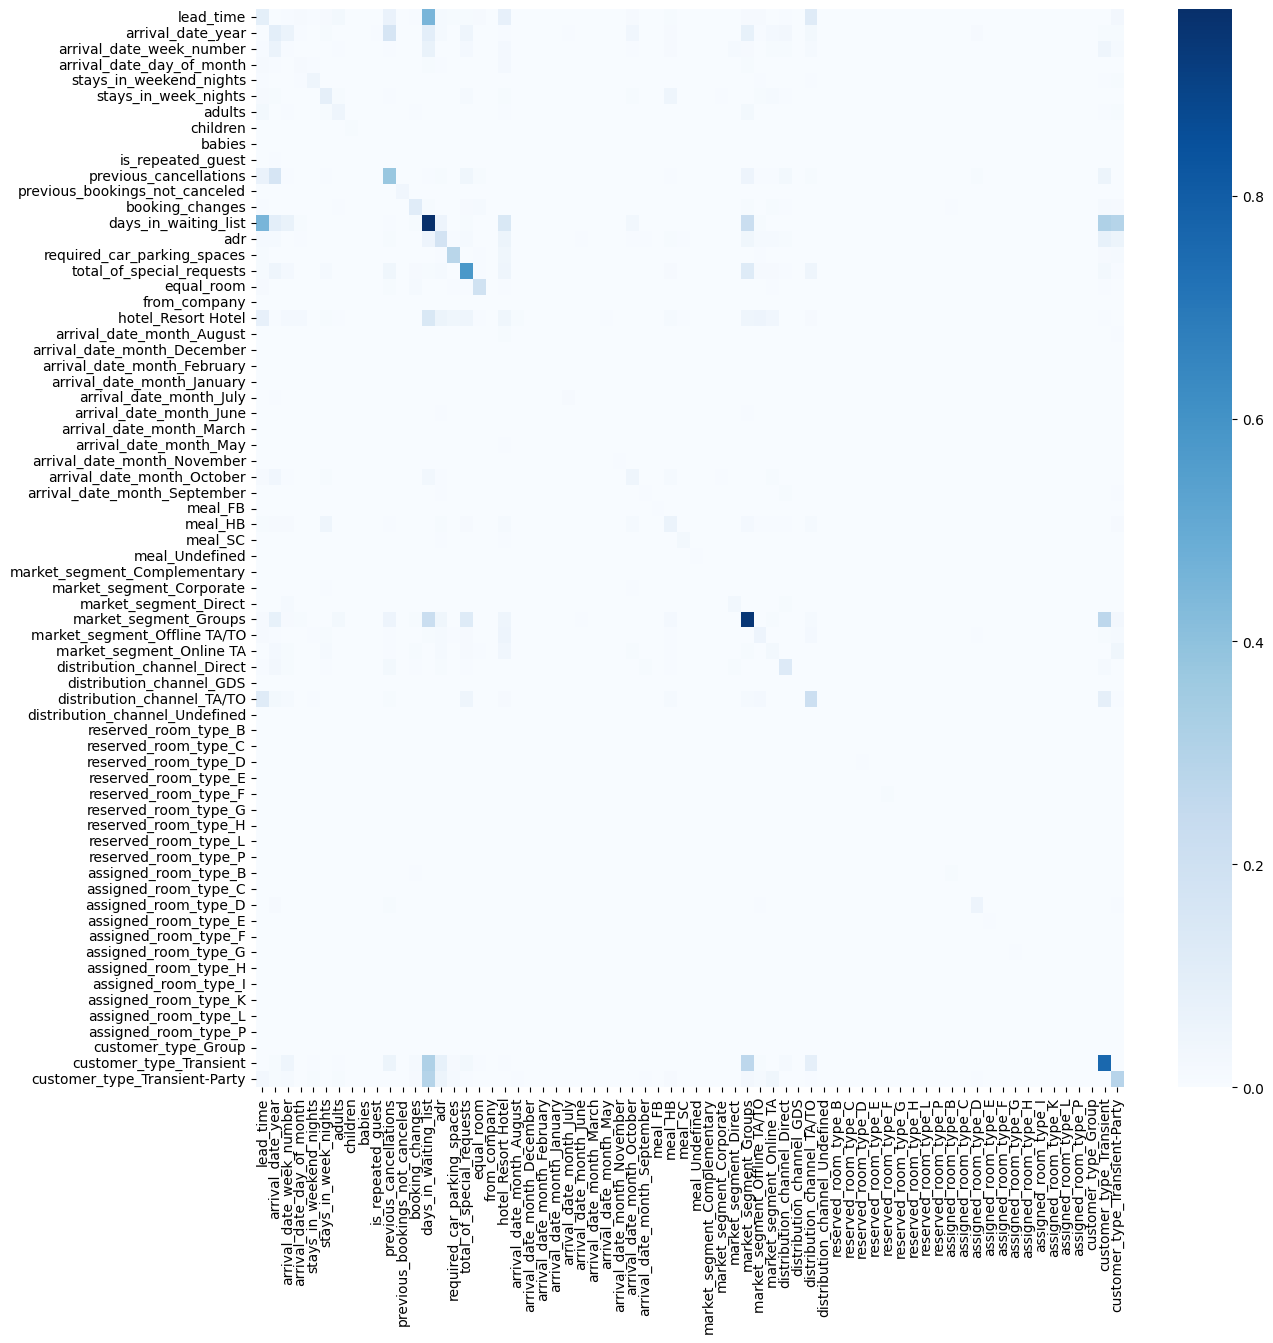

In [29]:
siv = np.abs(shap_interaction_values[0])

plt.figure(figsize=(14, 14))
sns.heatmap(siv, cmap='Blues', xticklabels=clf.feature_names_, yticklabels=clf.feature_names_)

is_canceled,0.0,1.0
wl_bins,,
"(-1, 0]",73406,41794
"(0, 20]",108,262
"(20, 50]",293,1146
"(50, 100]",563,579
"(100, 200]",258,262
"(200, 400]",117,110


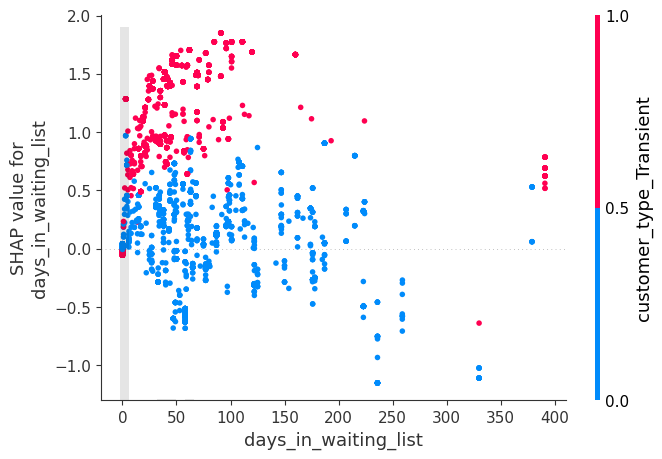

In [31]:
shap.plots.scatter(shap_values[:,'days_in_waiting_list'], color=shap_values)

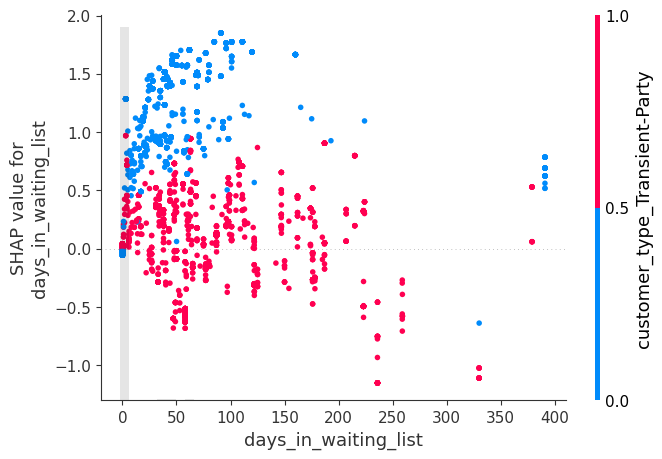

In [35]:
shap.plots.scatter(shap_values[:,'days_in_waiting_list'], color=shap_values[:,'customer_type_Transient-Party'])

In [39]:
temp = data.copy()
temp['wl_bins'] = pd.cut(temp['days_in_waiting_list'], bins=[-1,0,20,50,100,200,400])
print(pd.crosstab(temp['customer_type'],temp['wl_bins']))
pd.crosstab(data['customer_type'], temp['wl_bins'], values=temp['is_canceled'], aggfunc='mean')

wl_bins          (-1, 0]  (0, 20]  (20, 50]  (50, 100]  (100, 200]  (200, 400]
customer_type                                                                 
Contract            4072        1         3          0           0           0
Group                567        0         2          0           1           0
Transient          87133      246      1083        509         155          48
Transient-Party    23428      123       351        633         364         179


wl_bins,"(-1, 0]","(0, 20]","(20, 50]","(50, 100]","(100, 200]","(200, 400]"
customer_type,,,,,,
Contract,0.309921,0.000000,0.000000,NaN,NaN,NaN
Group,0.102293,NaN,0.000000,NaN,0.000000,NaN
Transient,0.395200,0.979675,0.997230,0.992141,0.993548,0.937500
Transient-Party,0.257768,0.170732,0.188034,0.116904,0.296703,0.363128


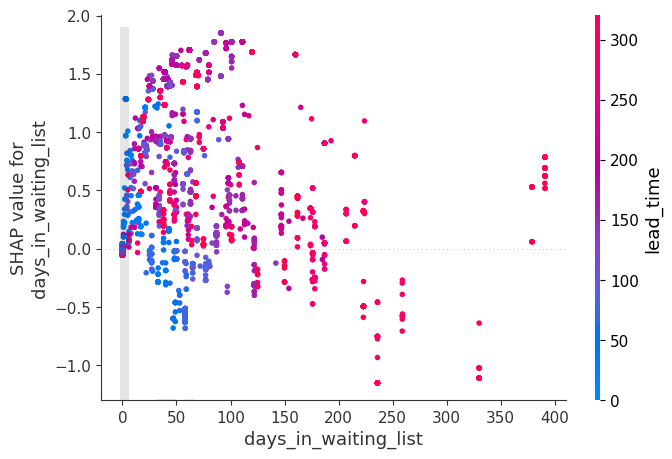

In [34]:
shap.plots.scatter(shap_values[:,'days_in_waiting_list'], color=shap_values[:,'lead_time'])

<Axes: xlabel='lead_time', ylabel='days_in_waiting_list'>

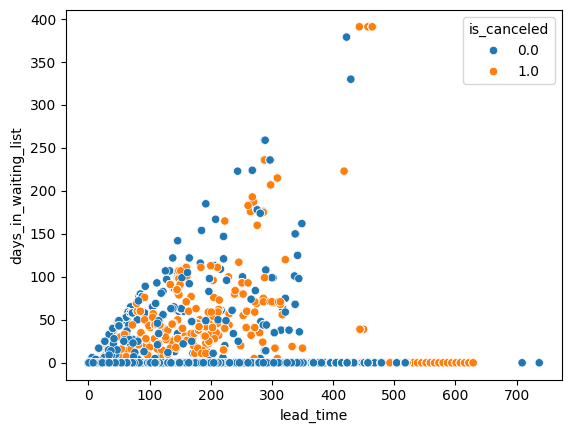

In [41]:
sns.scatterplot(y=data['days_in_waiting_list'], x=data['lead_time'], hue=data['is_canceled'])

In [ ]:
def objtective(trial):